# Exploring Zones 30

In [37]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch # for personalized legend
from matplotlib.lines import Line2D # for personalized legend
import os

import geopandas as gpd
import rasterio as rio
import fiona
import contextily
import osmnx
from shapely import geometry

In [2]:
# Set working directory
os.chdir("/Users/unaioyon/Desktop/masters_thesis/data/fra")

## 1. Geographic layers

In [3]:
# Import basic data
zones = gpd.read_file("zones_30/zones-30.shp")
ref = gpd.read_file("comptage_routier/referentiel/referentiel-comptages-routiers.shp")
arr = gpd.read_file("arrondissements/arrondissements.shp")
eau = gpd.read_file("eau/plan-de-voirie-voies-deau.shp")

In [4]:
zones.head(4)

nom_zca                   date_arr    type_arr arrdt  \
0  MarchÃ© Saint HonorÃ©                        NaN         NaN     1   
1                  Eylau  2014-01-14 02:00:00+01:00          PP    16   
2                Sorbier  2010-06-15 04:00:00+02:00  MDP AVEC C    20   
3                Moselle  2010-07-02 04:00:00+02:00  MDP AVEC C    19   

  reglement                                           geometry  
0   ZONE 30  POLYGON ((2.32942 48.86676, 2.32839 48.86722, ...  
1   ZONE 30  POLYGON ((2.28617 48.86325, 2.28543 48.86332, ...  
2   ZONE 30  POLYGON ((2.38750 48.86322, 2.38397 48.86631, ...  
3   ZONE 30  POLYGON ((2.37022 48.88294, 2.37090 48.88359, ...

## Zones 30
[Source: Paris Open Data](https://opendata.paris.fr/explore/dataset/zones-30/information/?disjunctive.nom_zca&disjunctive.arrdt&basemap=jawg.dark&location=12,48.8597,2.33318)

Relevant comments:
* CRS is EPSG:4326.
* 36 NAs for implementation date; 9 NAs for geometry.
* Date of implementation has the format YYYY-MM-DD HH:MM:SS+XX:YY.

In [5]:
# Create a new column with year of implementation
zones["year"] = zones["date_arr"].str[0:4]

## Arrondissements
[Source: Open Data Paris](https://opendata.paris.fr/explore/dataset/arrondissements/information/?disjunctive.c_ar&disjunctive.c_arinsee&disjunctive.l_ar&basemap=jawg.dark&location=12,48.85889,2.34692&dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6ImFycm9uZGlzc2VtZW50cyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuY19hciI6dHJ1ZSwiZGlzanVuY3RpdmUuY19hcmluc2VlIjp0cnVlLCJkaXNqdW5jdGl2ZS5sX2FyIjp0cnVlfX0sImNoYXJ0cyI6W3siYWxpZ25Nb250aCI6dHJ1ZSwidHlwZSI6ImNvbHVtbiIsImZ1bmMiOiJBVkciLCJ5QXhpcyI6Im5fc3FfYXIiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiIjMDAzMzY2In1dLCJ4QXhpcyI6ImxfYXIiLCJtYXhwb2ludHMiOjUwLCJzb3J0IjoiIn1dLCJ0aW1lc2NhbGUiOiIiLCJkaXNwbGF5TGVnZW5kIjp0cnVlLCJhbGlnbk1vbnRoIjp0cnVlfQ%3D%3D)

Relevant comments:
* CRS is EPSG:4326.

In [6]:
arr["a"] = 0

## 2. Traffic data (2010)
[Source: Open Data Paris](https://parisdata.opendatasoft.com/explore/dataset/comptages-routiers-permanents-historique/information/)

Relevant comments:
* CRS is EPSG:4326 for the referential database.
* The original traffic database has a weird column called "dessin" that does not exactly correspond to anything meaningful.
* A lot missing values are present for the two relevant variables (39% and 34%, respectively for hourly count and occupation rate).

In [7]:
# Import the data for 2010
traffic_10 = pd.read_csv("comptage_routier/weekly_2010/trafic_capteurs_2010_W29_20100722_20100729.txt",
                         delimiter = ";")

### Reference geometries for segments

Relevant comments:
* Some observations are exactly equivalent except for the geometry. When trying to assign the geometry to the original traffic datasets based on the index, it raises an error as observations are not uniquely identified. Thus, the solution implies dissolving (aggregating) geometries based on these identifiers.
* When assigning based on index, the problem is that for ref, the column "iu_ac" is encoded as "object" and for traffic_10, as "int64", so they do not correspond to each other. I convert "iu_ac" to integer on ref before proceeding.
* The number of observations collapsed in time, i.e., of present segments in 2010 measurings, is 3123, which is 93.28% of the total stations available in 2023. Maybe this just **implies that, back at the time, there were less stations? I need to double check with the time at which they opened.**

In [8]:
# Solving the multiple identification problem
ref["iu_ac"] = ref["iu_ac"].astype(int)
print(ref.shape[0], len(ref["iu_ac"].unique()))
ref = ref.dissolve(by = "iu_ac")
ref["iu_ac"] = ref.index # As it is set as index with dissolve()
print(ref.shape[0], len(ref["iu_ac"].unique()))

3739 3348
3348 3348


In [9]:
# Assigning the geometry to the original traffic dataset after re-indexing
traffic_10.set_index("iu_ac", inplace = True, drop = False)
traffic_10 = gpd.GeoDataFrame(traffic_10, geometry = ref["geometry"], crs = "EPSG:4326")

## 3. IRIS contours and statistics

In [7]:
# Import data for Paris 2022
iris = gpd.read_file("iris/iris_paris_22/1_DONNEES_LIVRAISON_2022-05-00266/IRIS-GE_2-0_SHP_LAMB93_D075-2022/IRIS_GE.SHP")

In [8]:
# Setting a comparable CRS
iris.to_crs(4326, inplace = True)

### Plotting

Text(0.1, 0.165, 'Source: own elaboration with Paris Open Data (2023).')

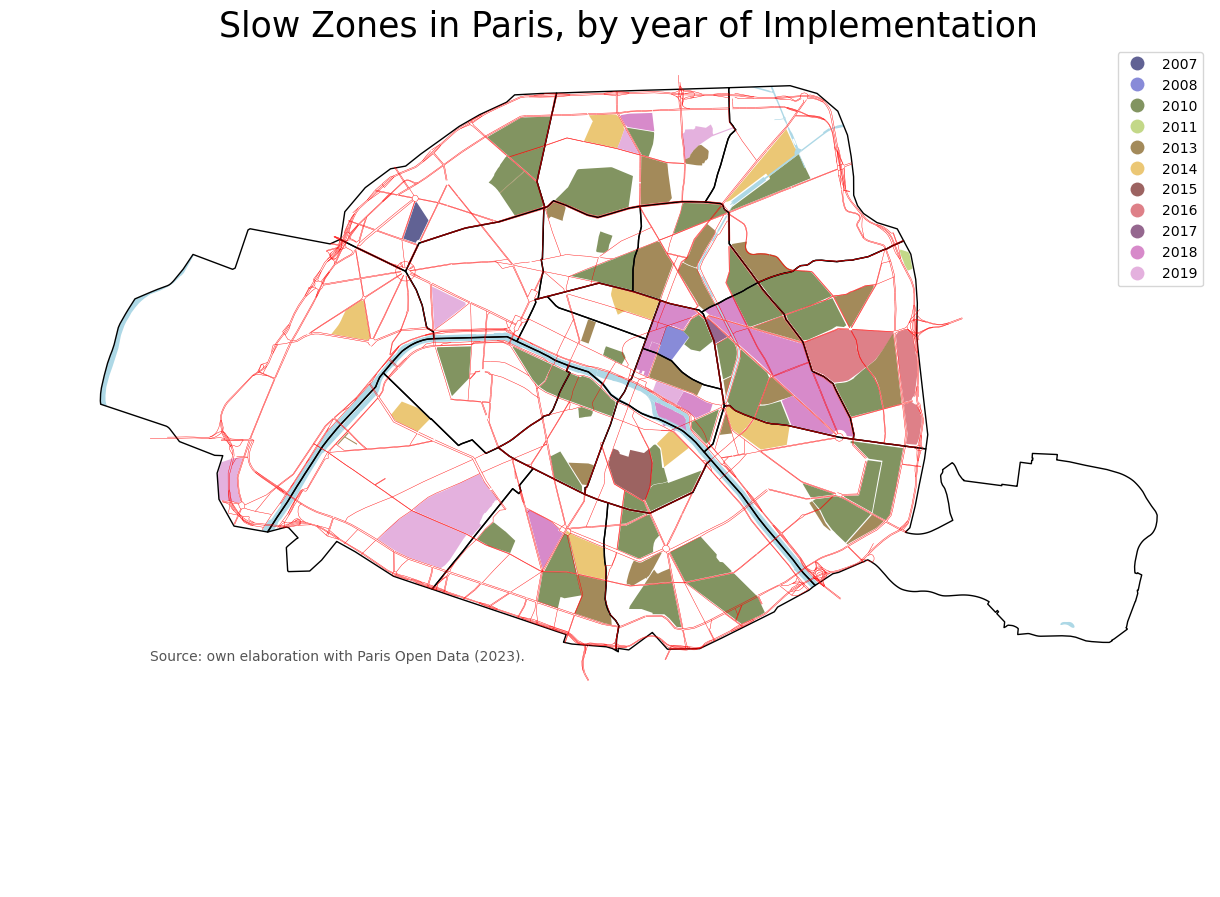

In [55]:
fig, ax = plt.subplots(1, figsize = (15, 15))
# Plotting everything together
zones.plot(ax = ax, column = "year", legend = True, cmap = "tab20b", alpha = 0.8)
arr.boundary.plot(ax = ax, linewidth = 1, color = "black")
eau.plot(ax = ax, color = "lightblue")
ref.plot(ax = ax, linewidth = 0.3, edgecolor = "red", legend = True)
ax.axis("off")
ax.set_title("Slow Zones in Paris, by year of Implementation", fontdict={"fontsize": "25", "fontweight" : "3"})
ax.annotate("Source: own elaboration with Paris Open Data (2023).",xy=(0.1, 0.165),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=10, color="#555555")


In [137]:
iris.head()

INSEE_COM                   NOM_COM  IRIS  CODE_IRIS          NOM_IRIS  \
0     75116  Paris 16e Arrondissement  6110  751166110        Auteuil 10   
1     75116  Paris 16e Arrondissement  6129  751166129        Auteuil 29   
2     75115  Paris 15e Arrondissement  6006  751156006           Javel 6   
3     75115  Paris 15e Arrondissement  5712  751155712  Saint-Lambert 12   
4     75115  Paris 15e Arrondissement  5910  751155910       Grenelle 10   

  TYP_IRIS                                           geometry  
0        H  POLYGON ((2.25868 48.84534, 2.25868 48.84561, ...  
1        H  POLYGON ((2.27257 48.84767, 2.27262 48.84773, ...  
2        H  POLYGON ((2.28215 48.83877, 2.28223 48.83897, ...  
3        H  POLYGON ((2.28941 48.83859, 2.28951 48.83875, ...  
4        H  POLYGON ((2.29092 48.84900, 2.29145 48.84961, ...

In [136]:
iris.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   INSEE_COM  992 non-null    object  
 1   NOM_COM    992 non-null    object  
 2   IRIS       992 non-null    object  
 3   CODE_IRIS  992 non-null    object  
 4   NOM_IRIS   992 non-null    object  
 5   TYP_IRIS   992 non-null    object  
 6   geometry   992 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 54.4+ KB


In [141]:
zones["date_arr"].unique()

array([nan, '2014-01-14 02:00:00+01:00', '2010-06-15 04:00:00+02:00',
       '2010-07-02 04:00:00+02:00', '2018-08-07 04:00:00+02:00',
       '2018-09-18 04:00:00+02:00', '2014-12-12 02:00:00+01:00',
       '2013-08-02 04:00:00+02:00', '2010-06-25 04:00:00+02:00',
       '2019-07-05 04:00:00+02:00', '2019-02-15 02:00:00+01:00',
       '2013-12-06 02:00:00+01:00', '2010-07-06 04:00:00+02:00',
       '2013-10-22 04:00:00+02:00', '2013-11-12 02:00:00+01:00',
       '2014-01-24 02:00:00+01:00', '2015-08-14 04:00:00+02:00',
       '2011-11-22 02:00:00+01:00', '2018-04-13 04:00:00+02:00',
       '2019-03-29 02:00:00+01:00', '2013-08-16 04:00:00+02:00',
       '2016-12-23 02:00:00+01:00', '2013-11-05 02:00:00+01:00',
       '2010-03-05 02:00:00+01:00', '2008-02-08 02:00:00+01:00',
       '2018-12-11 02:00:00+01:00', '2014-01-17 02:00:00+01:00',
       '2013-10-25 04:00:00+02:00', '2013-10-04 04:00:00+02:00',
       '2010-06-18 04:00:00+02:00', '2010-06-29 04:00:00+02:00',
       '2013-12-13 0

(2.2119354803446085, 2.4821327614636344, 48.81123297030858, 48.90647686112268)

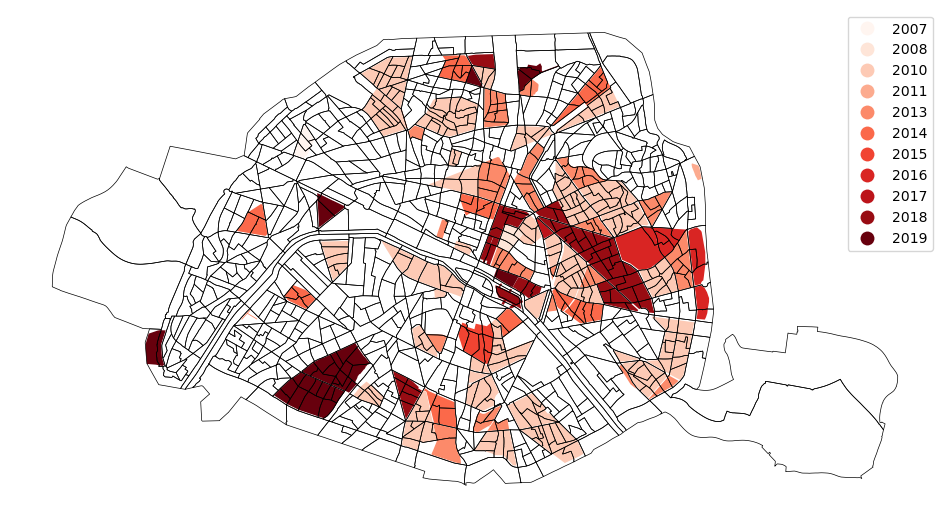

In [42]:
fig, ax = plt.subplots(1, figsize = (12, 12))
zones.plot(ax = ax, column = "year", legend = True, cmap = "Reds")
iris.boundary.plot(ax = ax, edgecolor = "black", linewidth = )
ax.axis("off")

## 4. Traffic data: selecting segments within a given region

In [23]:
arr.head(20)

n_sq_ar c_ar c_arinsee         l_ar              l_aroff    n_sq_co  \
0   750000011   11     75111  11Ã¨me Ardt           Popincourt  750001537   
1   750000004    4     75104   4Ã¨me Ardt      HÃ´tel-de-Ville  750001537   
2   750000020   20     75120  20Ã¨me Ardt        MÃ©nilmontant  750001537   
3   750000002    2     75102   2Ã¨me Ardt               Bourse  750001537   
4   750000005    5     75105   5Ã¨me Ardt            PanthÃ©on  750001537   
5   750000019   19     75119  19Ã¨me Ardt      Buttes-Chaumont  750001537   
6   750000013   13     75113  13Ã¨me Ardt             Gobelins  750001537   
7   750000014   14     75114  14Ã¨me Ardt         Observatoire  750001537   
8   750000016   16     75116  16Ã¨me Ardt                Passy  750001537   
9   750000018   18     75118  18Ã¨me Ardt    Buttes-Montmartre  750001537   
10  750000007    7     75107   7Ã¨me Ardt       Palais-Bourbon  750001537   
11  750000001    1     75101     1er Ardt               Louvre  750001537   
12  750000006    6     75106   6Ã¨me Ardt           Luxembourg  750001537   
13  750000012   12     75112  12Ã¨me Ardt              Reuilly  750001537   
14  750000017   17     75117  17Ã¨me Ardt  Batignolles-Monceau  750001537   
15  750000010   10     75110  10Ã¨me Ardt            EntrepÃ´t  750001537   
16  750000008    8     75108   8Ã¨me Ardt             ÃlysÃ©e  750001537   
17  750000015   15     75115  15Ã¨me Ardt            Vaugirard  750001537   
18  750000003    3     75103   3Ã¨me Ardt               Temple  750001537   
19  750000009    9     75109   9Ã¨me Ardt               OpÃ©ra  750001537   

         surface     perimetre  \
0   3.665442e+06   8282.011886   
1   1.600586e+06   5420.908434   
2   5.983446e+06  10704.940486   
3   9.911537e+05   4554.104360   
4   2.539375e+06   6239.195396   
5   6.792651e+06  11253.182479   
6   7.149311e+06  11546.546526   
7   5.614877e+06  10317.483310   
8   1.637254e+07  17416.109657   
9   5.996051e+06   9916.464176   
10  4.090057e+06   8099.424883   
11  1.824613e+06   6054.936862   
12  2.153096e+06   6483.686786   
13  1.631478e+07  24089.666298   
14  5.668835e+06  10775.579516   
15  2.891739e+06   6739.375055   
16  3.880036e+06   7880.533268   
17  8.494994e+06  13678.798315   
18  1.170883e+06   4519.263648   
19  2.178303e+06   6471.588290   

                                             geometry  a  
0   POLYGON ((2.39624 48.85415, 2.39708 48.85308, ...  0  
1   POLYGON ((2.36851 48.85573, 2.36900 48.85374, ...  0  
2   POLYGON ((2.41277 48.87547, 2.41284 48.87524, ...  0  
3   POLYGON ((2.35152 48.86443, 2.35095 48.86341, ...  0  
4   POLYGON ((2.36443 48.84614, 2.36484 48.84584, ...  0  
5   POLYGON ((2.38943 48.90122, 2.39014 48.90108, ...  0  
6   POLYGON ((2.37491 48.83801, 2.37698 48.83610, ...  0  
7   POLYGON ((2.33381 48.84061, 2.33673 48.83965, ...  0  
8   POLYGON ((2.27427 48.87837, 2.27749 48.87796, ...  0  
9   POLYGON ((2.36580 48.88554, 2.36469 48.88437, ...  0  
10  POLYGON ((2.32090 48.86306, 2.32094 48.86305, ...  0  
11  POLYGON ((2.32801 48.86992, 2.32997 48.86851, ...  0  
12  POLYGON ((2.34459 48.85405, 2.34428 48.85375, ...  0  
13  POLYGON ((2.41388 48.83357, 2.41401 48.83357, ...  0  
14  POLYGON ((2.29517 48.87396, 2.29504 48.87378, ...  0  
15  POLYGON ((2.36469 48.88437, 2.36485 48.88436, ...  0  
16  POLYGON ((2.32584 48.86956, 2.32569 48.86954, ...  0  
17  POLYGON ((2.29932 48.85217, 2.30088 48.85118, ...  0  
18  POLYGON ((2.36383 48.86750, 2.36389 48.86747, ...  0  
19  POLYGON ((2.33978 48.88203, 2.33982 48.88202, ...  0

In [39]:
# Using within(), and selecting the 14th arrondissement, for instance
arr14 = arr.loc[7,"geometry"]
ref14 = ref[ref.geometry.within(arr14)]

<AxesSubplot: >

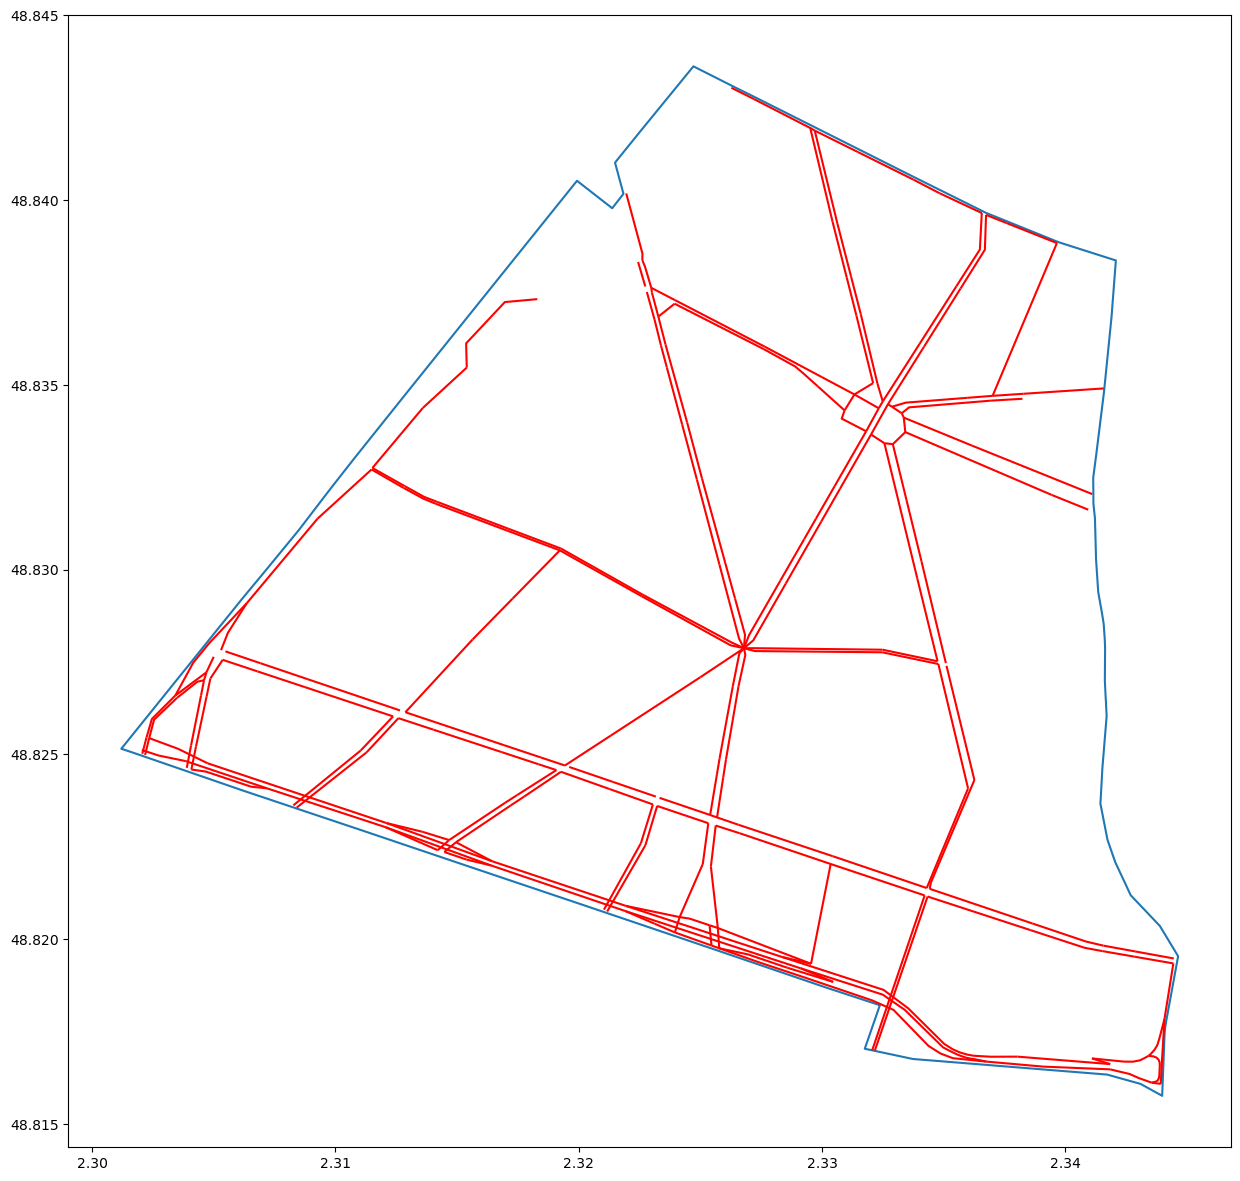

In [45]:
# Plot to see how it looks like
fig, ax = plt.subplots(1, figsize = (15, 15))
arr[arr["c_ar"] == "14"].boundary.plot(ax = ax)
ref14.plot(ax=ax, color = "red")

**Relevant discussion**
 * Using within() may be problematic, as it needs the whole SF to be within the relevant area. Nonetheless, overlap() may be better as I am trying to classify segments which **pass** through a given arrondissement/IRIS/slow zone.
 * When it comes to slow zones, as shown in the first graph, traffic segments have little to no overlap with them (unless in the very borders). This may be problematic, and I may have to find an alternative method of "assigning" slow zones to traffic segments.

# 2. Cadaster data
**Source**: [Cadastre Etalab](https://cadastre.data.gouv.fr/datasets/cadastre-etalab), using the GeoJSON driver.
In the metadata, DV3F is stored in EPSG:2154. Thus, I have to choose a common CRS for both the cadaster and the DV3F datasets. When transforming the latter to the former's CRS, I obtain reasonably close data, but geometry do not exactly overlap. Under visual inspection, nonetheless, for one observation, these differences are impossible to see.

In [3]:
# Import cadaster data: parcelles, département 75, millésime 1er janvier 2023
cad = gpd.read_file("cadastre/cadastre-75-parcelles.json")

In [30]:
cad.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [56]:
# Import DV3F data (subset to compare)
paris = gpd.read_file("/Users/unaioyon/Desktop/DV3F_new/mod/mutations_paris.shp")

In [67]:
# Generate centroid & put as active geometry for the following map
paris["centroid"] = paris["geometry"].centroid
paris.to_crs("EPSG:4326", inplace=True)
paris.set_geometry("centroid", inplace=True)
paris.to_crs("EPSG:4326", inplace=True)

(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)
(0.8980392156862745, 0.96, 0.6737254901960784, 1.0)


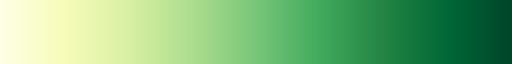

In [91]:
# Manually access a colormap
cmap_tab20 = plt.cm.get_cmap("tab20")
print(cmap_tab20(0.2))
cmap_tab20

cmap_YlGn = plt.cm.get_cmap("YlGn")
print(cmap_YlGn(0.2))
cmap_YlGn

In [60]:
# Select zones with geometry and year of implementation
zones_sub = zones[(zones["geometry"].isna() == False) & (zones["date_arr"].isna() == False)].copy()
zones_sub["year_num"] = zones_sub["year"].astype(int)

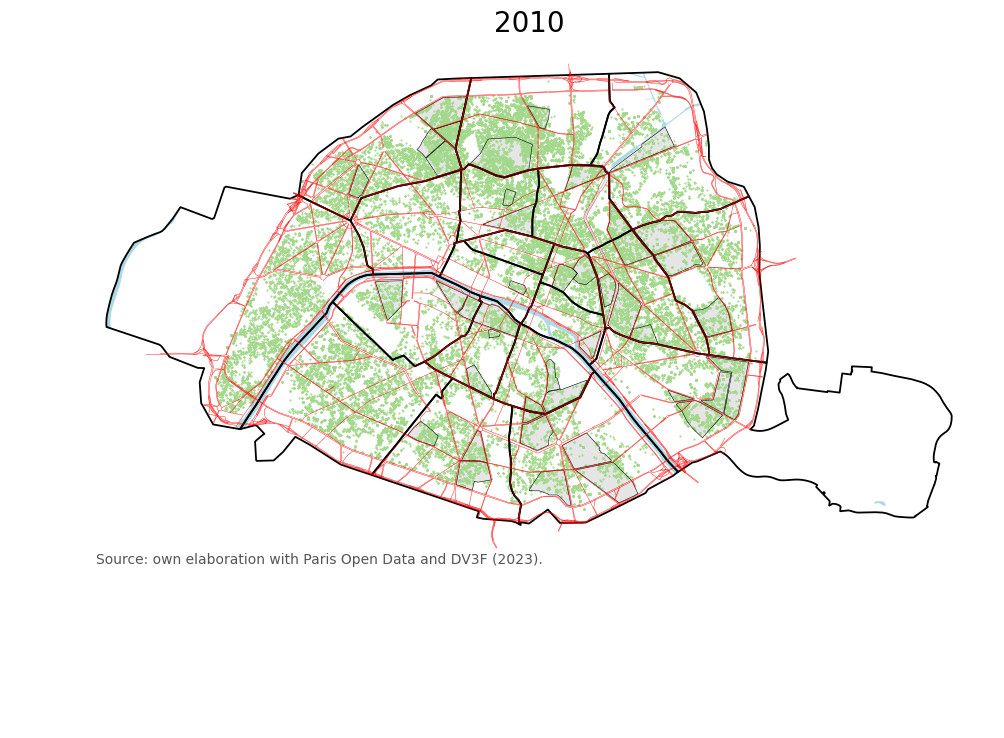

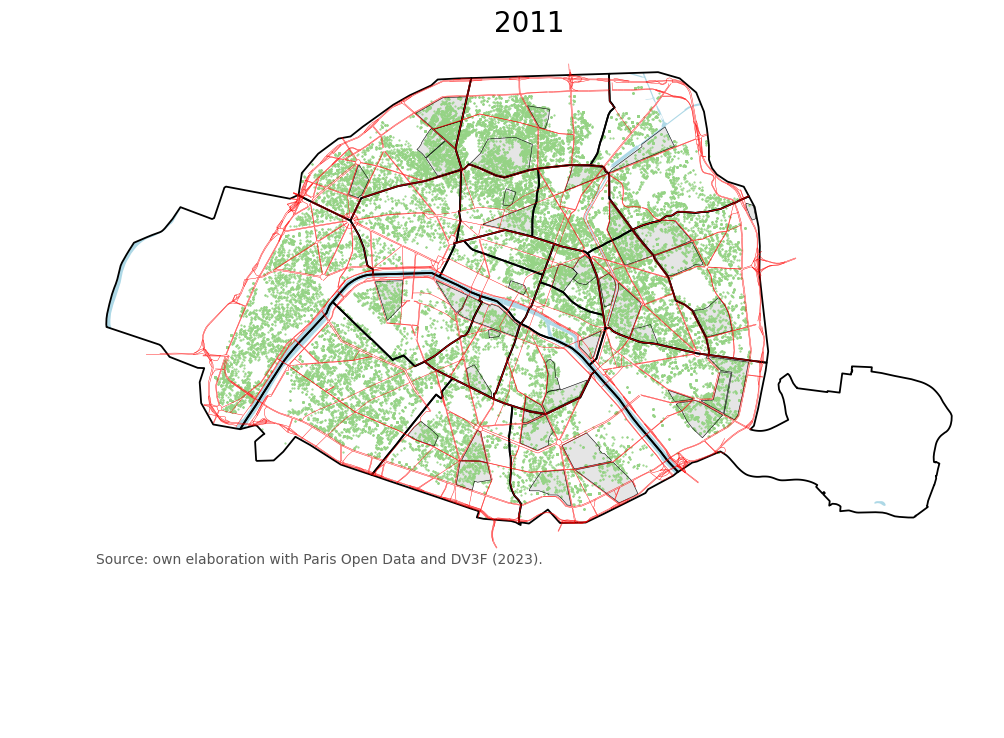

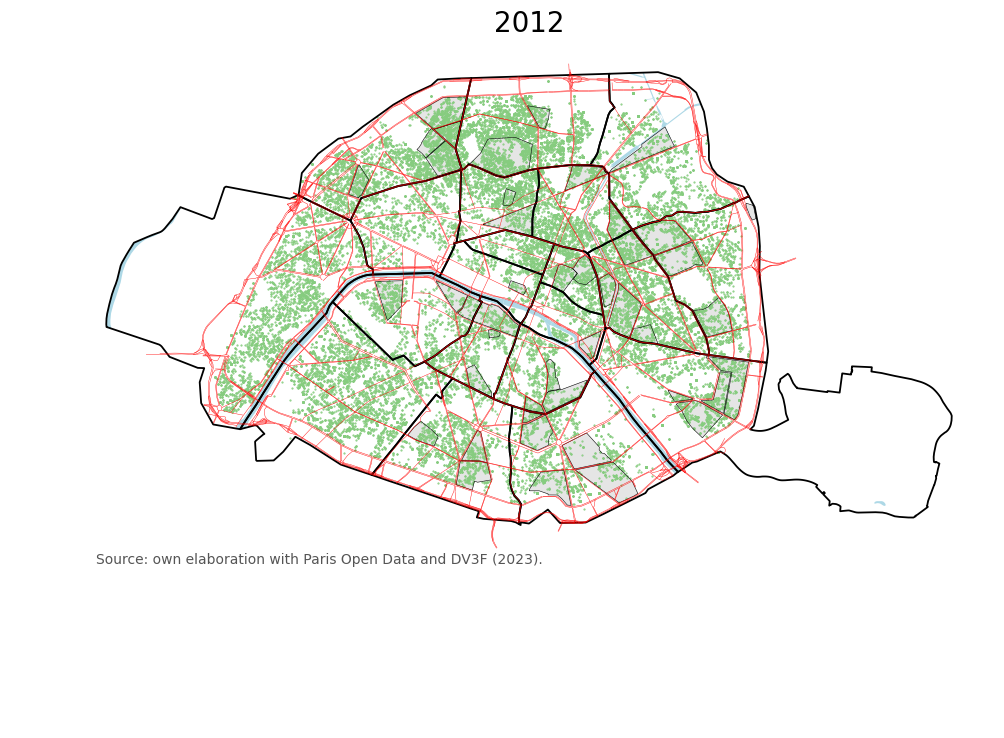

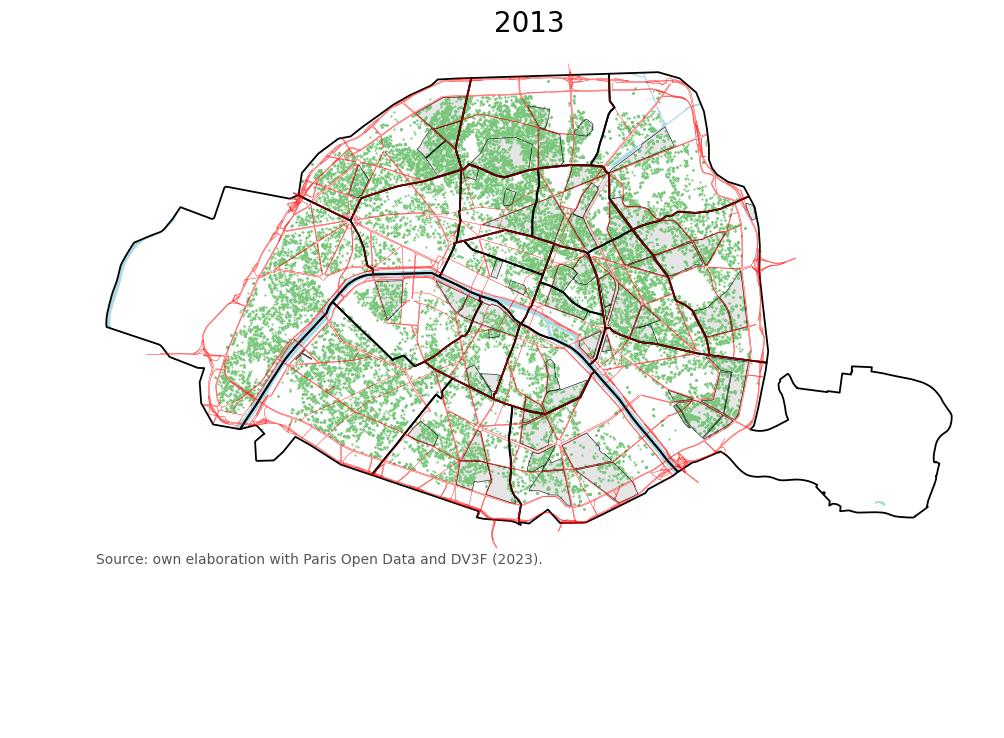

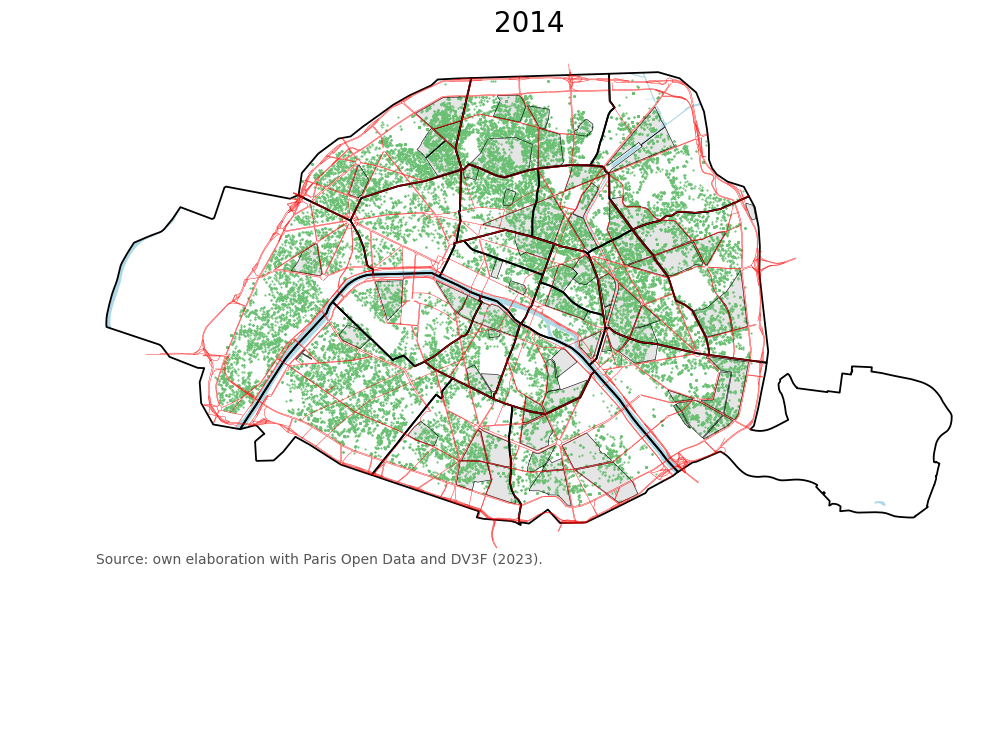

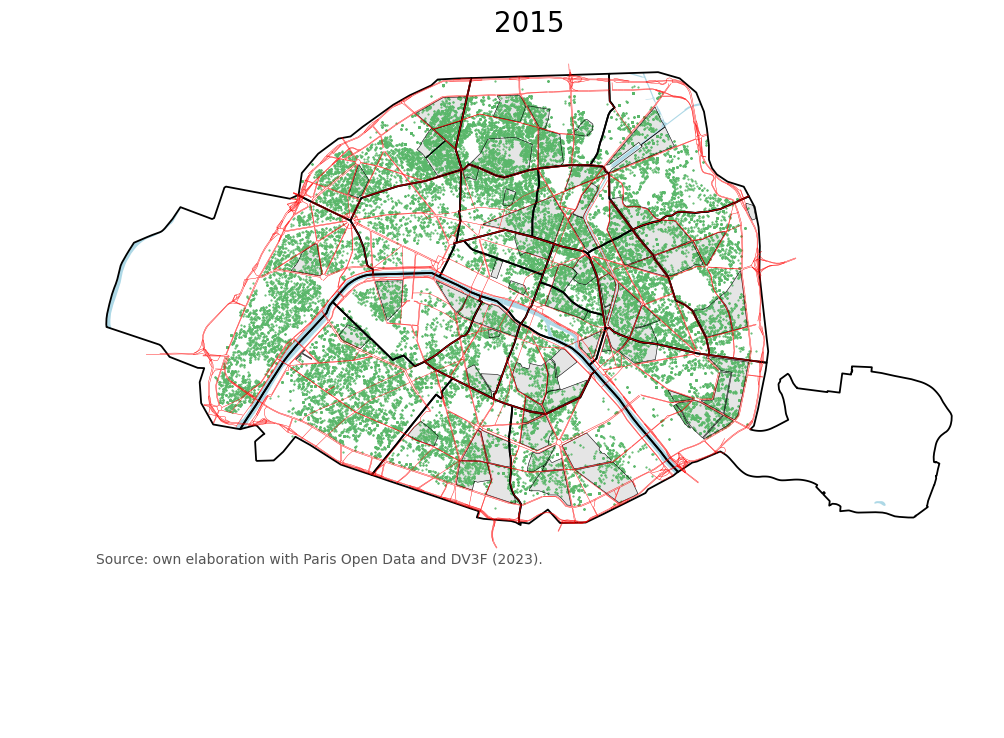

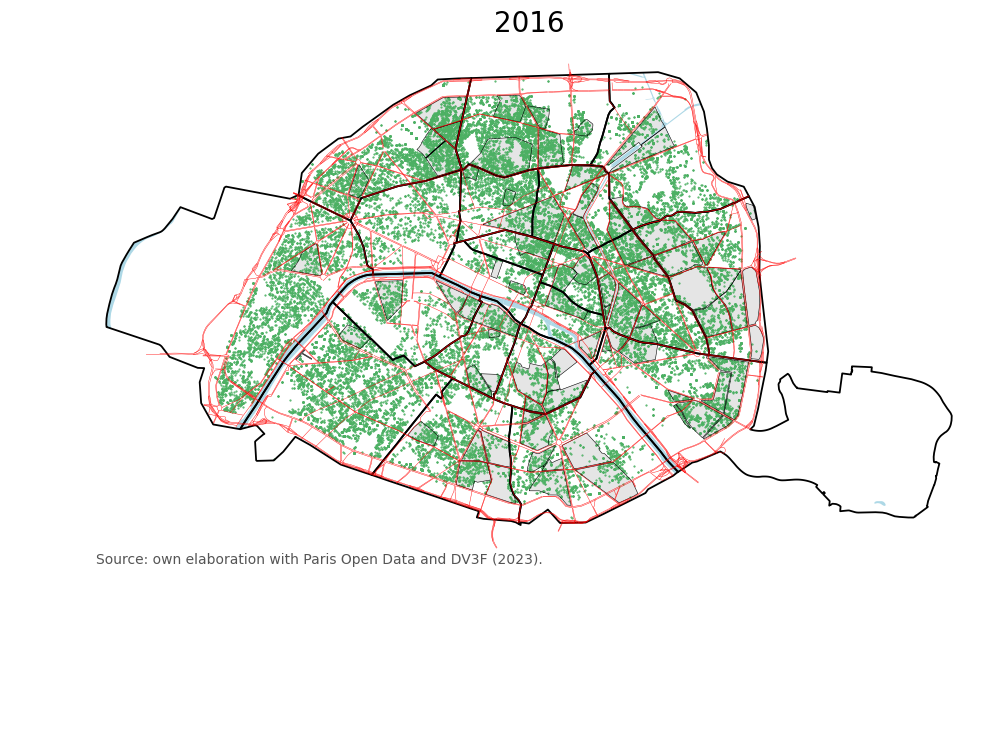

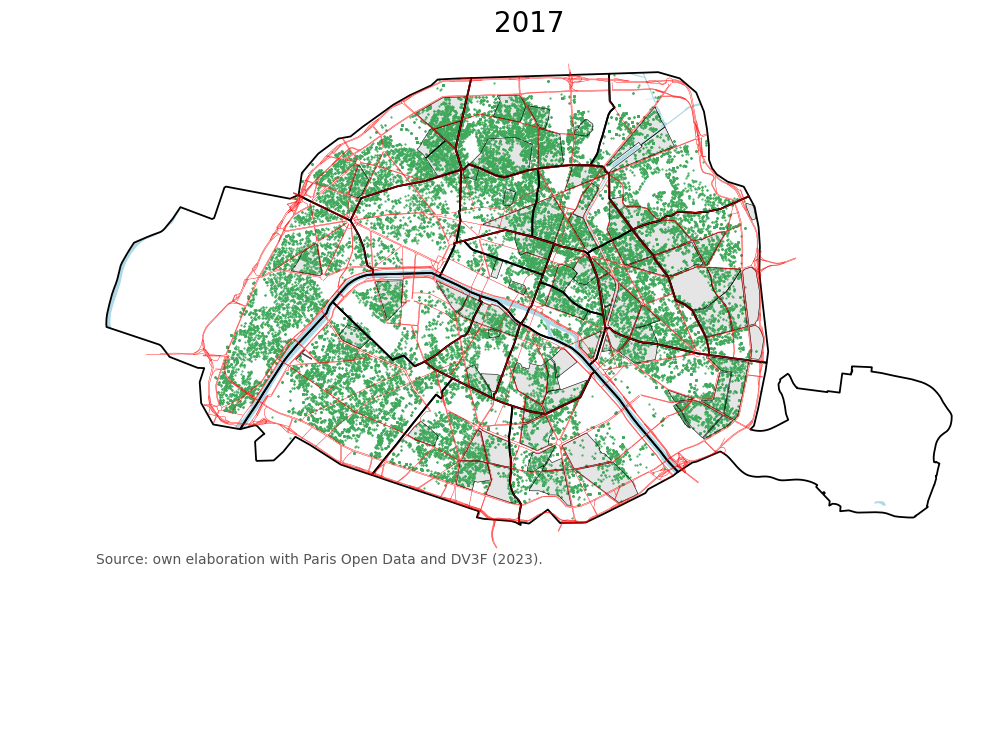

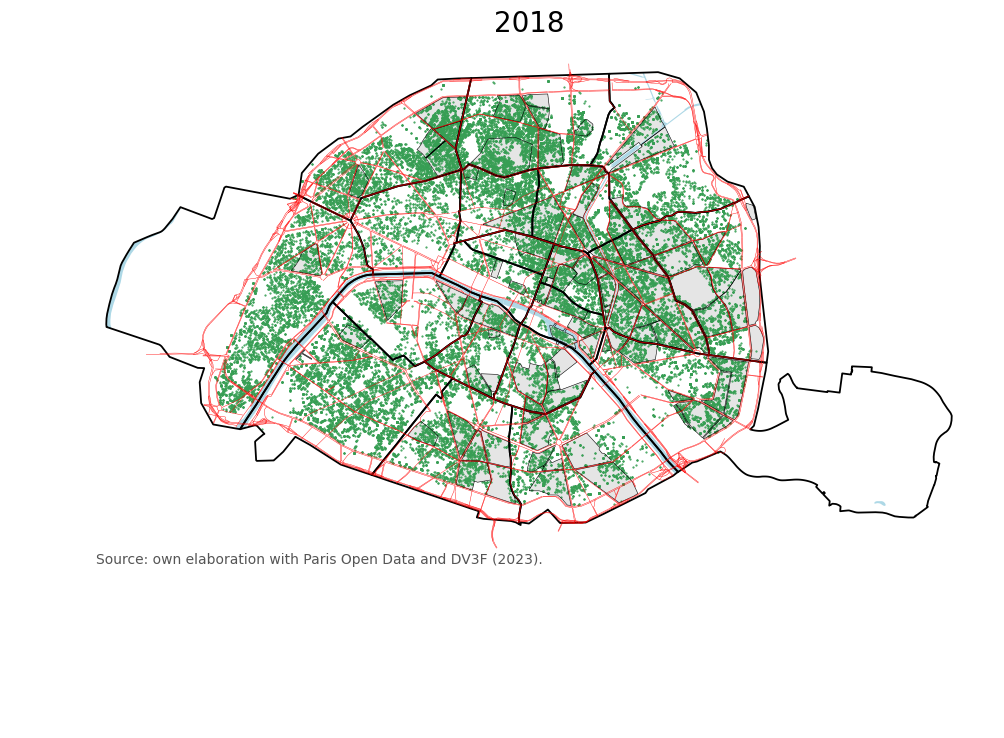

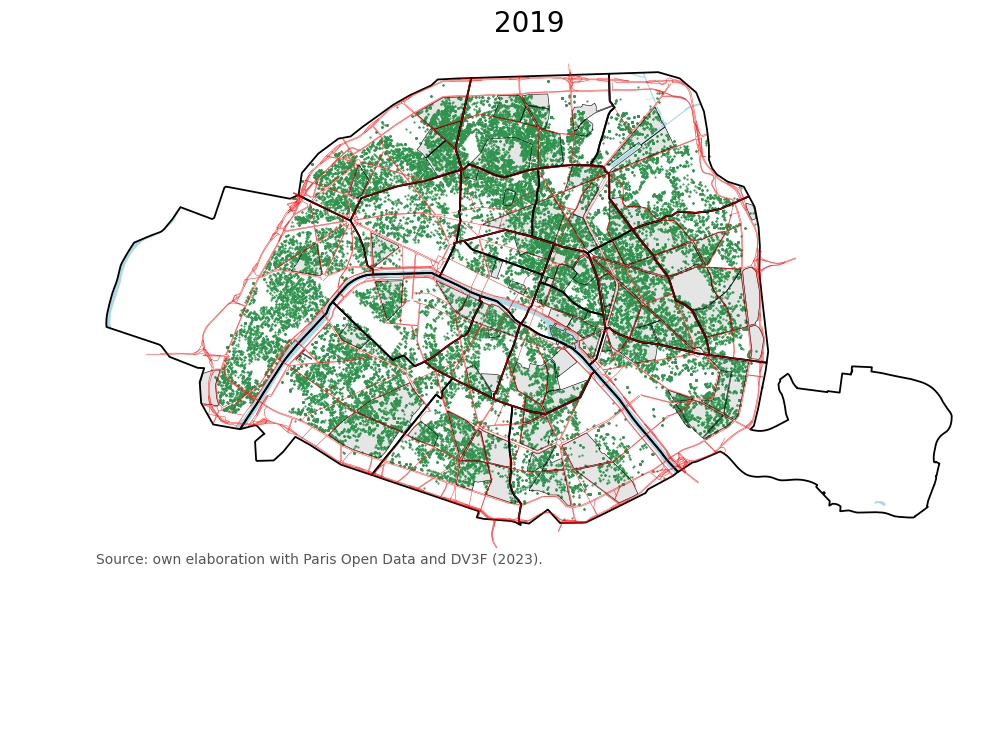

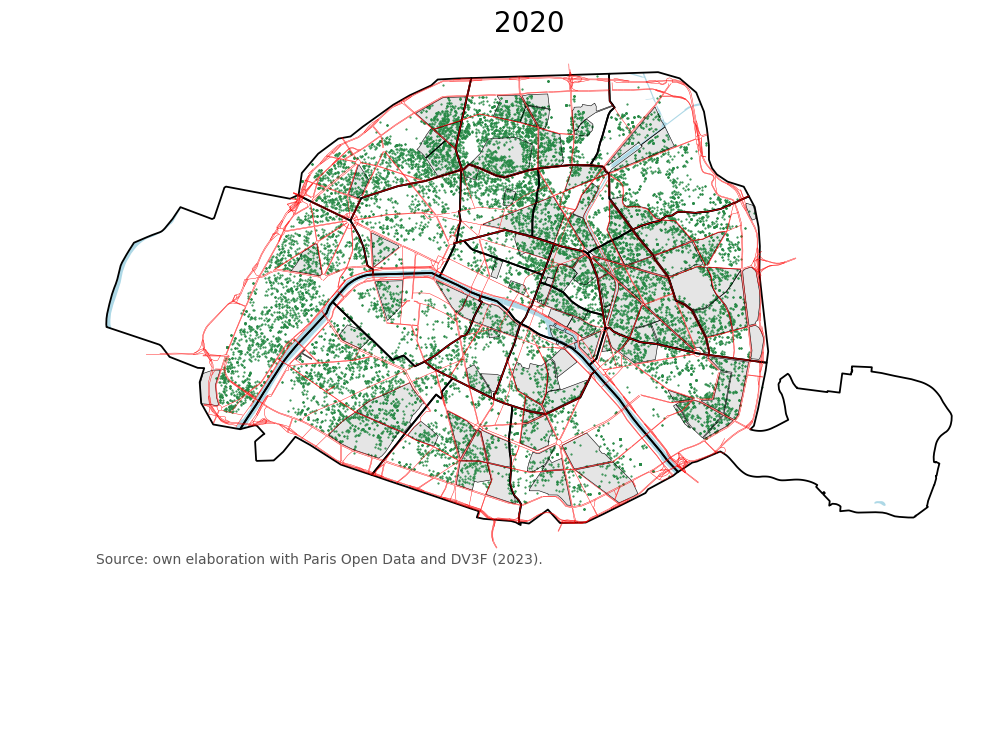

In [113]:
# Plot the location of each transation for each year
years_sorted = paris["anneemut"].unique()
years_sorted.sort()
for i in years_sorted:
    # Set figure
    fig, ax = plt.subplots(1, figsize = (12, 12))
    # Set color for each year
    # j = list(paris["anneemut"].unique()).index(i)/len(paris["anneemut"].unique())
    j = 0.4 + list(years_sorted).index(i)/30
    # Plots
    zones_sub.loc[zones_sub["year_num"] <= i].plot(ax = ax, color = "black", alpha = 0.1)
    zones_sub.loc[zones_sub["year_num"] <= i].boundary.plot(ax = ax, color = "black", linewidth = 0.4)
    paris.loc[paris["anneemut"] == i].plot(ax = ax, markersize = 0.3, color = cmap_YlGn(j))
    arr.boundary.plot(ax = ax, linewidth = 1.3, color = "black")
    eau.plot(ax = ax, color = "lightblue")
    ref.plot(ax = ax, linewidth = 0.3, edgecolor = "red", legend = True)
    ax.axis("off")
    ax.set_title(str(int(i)), fontdict={"fontsize": "20", "fontweight" : "3"})
    ax.annotate("Source: own elaboration with Paris Open Data and DV3F (2023).",xy=(0.08, 0.155),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=10, color="#555555")
    fig.savefig("/Users/unaioyon/Desktop/masters_thesis/graphs/map_year{}.png".format(str(int(i))), dpi=300)

In [130]:
# Creating a categorical anneemut
paris.insert(7, "anneemut_cat", paris["anneemut"].astype(int).astype(str))

In [127]:
paris.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 427694 entries, 0 to 427693
Data columns (total 53 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   idmutation    427694 non-null  float64 
 1   idmutinvar    427694 non-null  object  
 2   idopendata    427694 non-null  object  
 3   idnatmut      427694 non-null  float64 
 4   codservch     324989 non-null  object  
 5   refdoc        324989 non-null  object  
 6   datemut       427694 non-null  object  
 7   anneemut_cat  427694 non-null  object  
 8   anneemut      427694 non-null  float64 
 9   moismut       427694 non-null  float64 
 10  coddep        427694 non-null  float64 
 11  libnatmut     427694 non-null  object  
 12  vefa          427694 non-null  int64   
 13  valeurfonc    427544 non-null  float64 
 14  nblot         427694 non-null  float64 
 15  nbcomm        427694 non-null  float64 
 16  l_codinsee    427694 non-null  object  
 17  nbsection     427694 

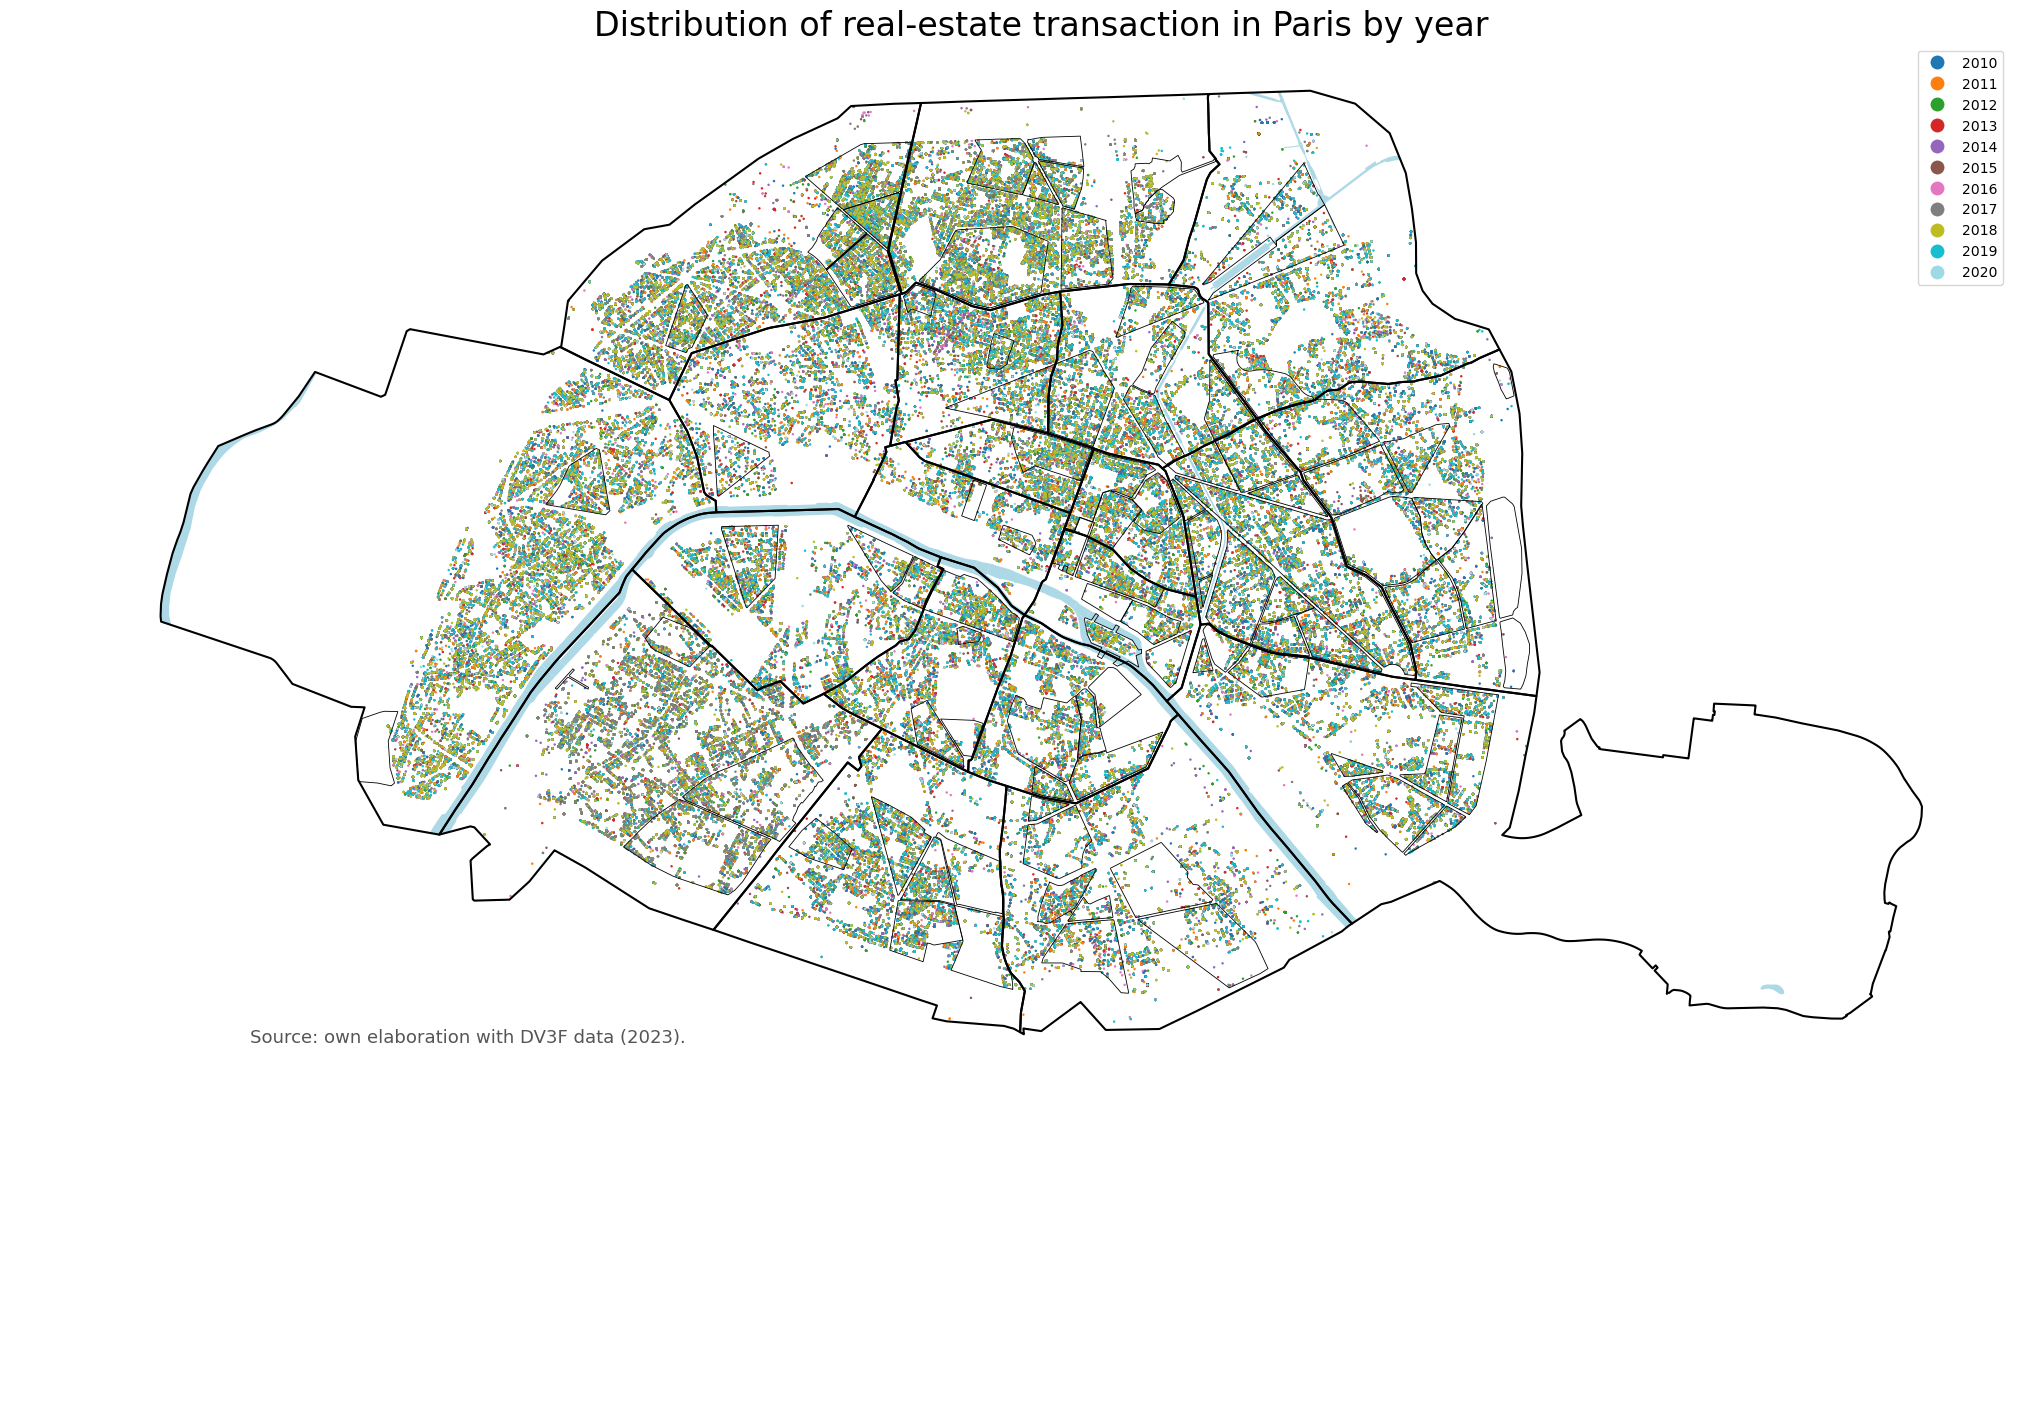

In [135]:
# Plot transactions by year over slow zones in Paris
fig, ax = plt.subplots(1, figsize = (25, 25))
arr.boundary.plot(ax = ax, linewidth = 1.5, color = "black")
eau.plot(ax = ax, color = "lightblue")
paris.plot(ax = ax, column = "anneemut_cat", cmap = "tab20", legend = True, categorical = True, markersize = 0.6)
zones[(zones["geometry"].isna() == False) & (zones["date_arr"].isna() == False)].boundary.plot(ax = ax, color = "black", linewidth = 0.6)
ax.axis("off")
ax.set_title("Distribution of real-estate transaction in Paris by year", fontdict={"fontsize": "24", "fontweight" : "3"})
ax.annotate("Source: own elaboration with DV3F data (2023).",xy=(0.1, 0.16),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=13, color="#555555")
fig.savefig("/Users/unaioyon/Desktop/masters_thesis/graphs/years_transactions.png", dpi=300)

____________

In [55]:
# Compare both geometries for a given parcel
print(paris.loc[0, "geometry"])
print(cad.loc[cad["id"] == "75108000BG0024", "geometry"])

POLYGON ((2.306773800923121 48.871532779769126, 2.3067184059913606 48.87145412612057, 2.306706103742887 48.87143606799551, 2.3066652820163385 48.871378993034114, 2.306635520113998 48.87134113814069, 2.3065173128401164 48.871382632561506, 2.306628560158998 48.87153625536887, 2.3066538618318044 48.87157120652203, 2.306773800923121 48.871532779769126))
20167    POLYGON ((2.30652 48.87138, 2.30664 48.87134, ...
Name: geometry, dtype: geometry


<AxesSubplot: >

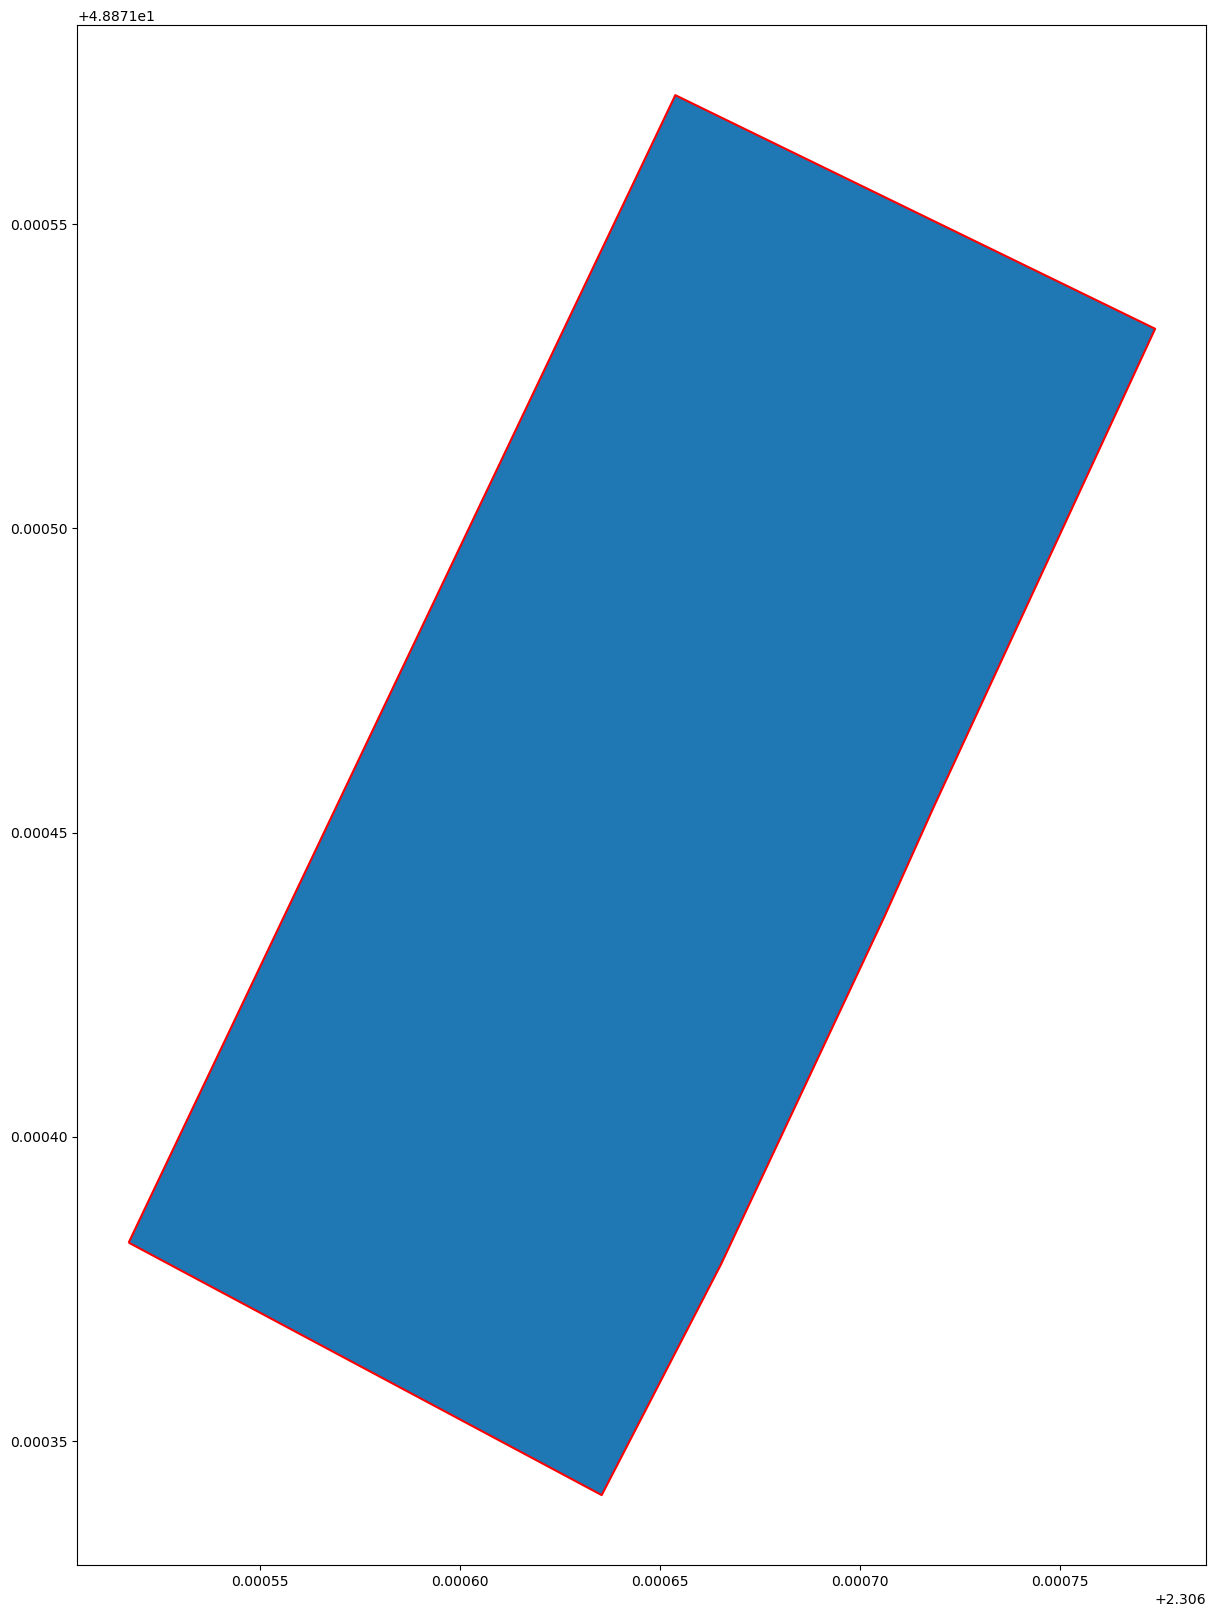

In [54]:
# Plotting to visualize these differences: negligible
fig, ax = plt.subplots(1, figsize = (20, 20))
paris.loc[paris["idmutation"] == 10311137, "geometry"].plot(ax = ax)
cad.loc[cad["id"] == "75108000BG0024", "geometry"].boundary.plot(ax = ax, color = "red")